In [12]:
import pandas as pd
import re
import random
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover import StopWordRemover  # Add this import
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk

# Download NLTK resources if not already downloaded
nltk.download('punkt')

# Load data
df = pd.read_csv('data-mudik-v2.csv')

# Select relevant columns
df = df[['full_text', 'username', 'created_at']]

# Drop duplicates and NaN values
df = df.drop_duplicates(subset=['full_text'])
df = df.dropna()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abid_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Function to clean Twitter text
def clean_twitter_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Delete mentions
    text = re.sub(r'#\W', '', text)  # Delete hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Delete retweets
    text = re.sub(r'https?://\S+', '', text)  # Delete URLs
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)  # Delete non-alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()  # Delete extra spaces
    return text

df['full_text'] = df['full_text'].apply(clean_twitter_text)

# Normalize text
norm = {'yg': 'yang', 'nggak': 'tidak', 'buat': 'untuk'}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))

# Remove stopwords
more_stop_words = ['tidak']
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemoverFactory().create_stop_word_remover()  # Create StopWordRemover instance

def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

df['full_text'] = df['full_text'].apply(lambda x: stopword(x))

# Tokenization and stemming
def stemming(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = text.split()
    stems = [stemmer.stem(token) for token in tokens]
    return ' '.join(stems)

df['full_text'] = df['full_text'].apply(stemming)

# Convert to lowercase
df['full_text'] = df['full_text'].str.lower()

# Save processed data to CSV
df.to_csv('data-mudik-processed.csv', index=False)

In [21]:
# Sentiment Analysis with TextBlob
data = pd.read_csv('data-mudik-processed.csv')
data_tweet = list(data['full_text'])

total_positif = total_negatif = total_netral = 0
status = []

for tweet in data_tweet:
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0.0:
        status.append('Positif')
        total_positif += 1
    elif analysis.sentiment.polarity == 0.0:
        status.append('Netral')
        total_netral += 1
    else:
        status.append('Negatif')
        total_negatif += 1

data['klasifikasi'] = status

# Save analyzed data to CSV
data.to_csv('data-mudik-sentiment.csv', index=False)

In [23]:
# Classification with Naive Bayes Classifier
dataset = [(row['full_text'], row['klasifikasi']) for idx, row in data.iterrows()]
random.shuffle(dataset)

train_set = dataset[:int(len(dataset)/2)]
test_set = dataset[int(len(dataset)/2):]

cl = NaiveBayesClassifier(train_set)

print('Akurasi Test:', cl.accuracy(test_set))

# Apply classifier to all data
data['klasifikasi_bayes'] = [cl.classify(tweet) for tweet, label in dataset]

# Save final output to CSV
data.to_csv('data-mudik-final.csv', index=False)

Akurasi Test: 0.9168646080760094


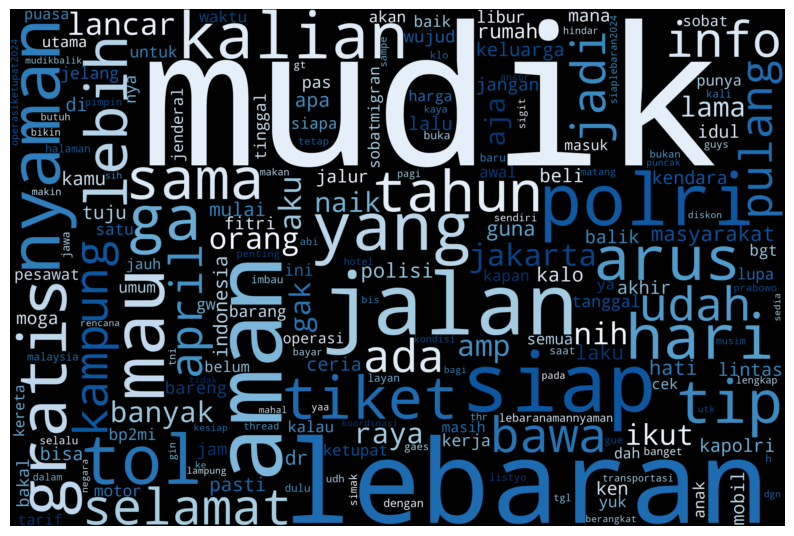

In [24]:
# Visualization - Word Cloud
all_words = ' '.join(data['full_text'])
wordcloud = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Blues_r',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

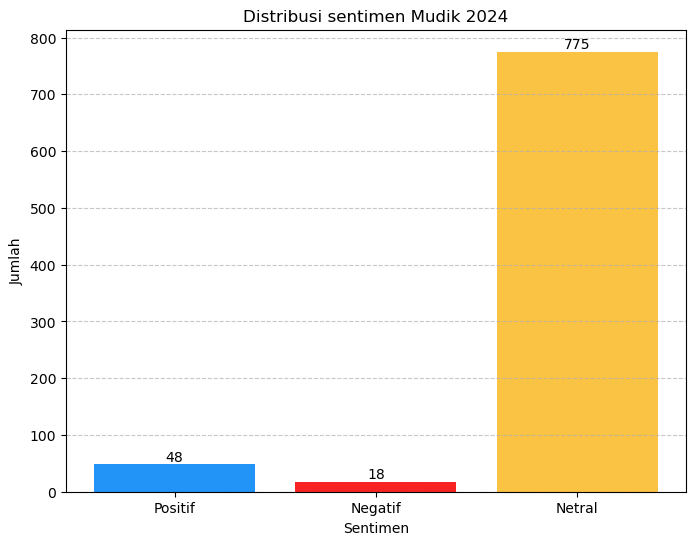

In [25]:
# Visualization - Bar Chart
labels = ['Positif', 'Negatif', 'Netral']
counts = [total_positif, total_negatif, total_netral]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Distribusi sentimen Mudik 2024')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()